In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
import joblib

In [2]:
df = pd.read_csv("mat.csv")
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [3]:
df.shape

(395, 33)

In [4]:
df.isna().sum()

school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
G1            0
G2            0
G3            0
dtype: int64

In [5]:
scores = df.columns[df.columns.str.contains('G')].tolist()
scores

['G1', 'G2', 'G3']

In [6]:
df.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000
mean,16.696203,2.749367,2.521519,1.448101,2.035443,0.334177,3.944304,3.235443,3.108861,1.481013,2.291139,3.554430,5.708861,10.908861,10.713924,10.415190
std,1.276043,1.094735,1.088201,0.697505,0.839240,0.743651,0.896659,0.998862,1.113278,0.890741,1.287897,1.390303,8.003096,3.319195,3.761505,4.581443
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,8.000000,9.000000,8.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,4.000000,11.000000,11.000000,11.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,8.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,19.000000,19.000000,20.000000


In [7]:
cor=df.corr()


In [8]:
cor

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
age,1.000000,-0.163658,-0.163438,0.070641,-0.004140,0.243665,0.053940,0.016434,0.126964,0.131125,0.117276,-0.062187,0.175230,-0.064081,-0.143474,-0.161579
Medu,-0.163658,1.000000,0.623455,-0.171639,0.064944,-0.236680,-0.003914,0.030891,0.064094,0.019834,-0.047123,-0.046878,0.100285,0.205341,0.215527,0.217147
Fedu,-0.163438,0.623455,1.000000,-0.158194,-0.009175,-0.250408,-0.001370,-0.012846,0.043105,0.002386,-0.012631,0.014742,0.024473,0.190270,0.164893,0.152457
traveltime,0.070641,-0.171639,-0.158194,1.000000,-0.100909,0.092239,-0.016808,-0.017025,0.028540,0.138325,0.134116,0.007501,-0.012944,-0.093040,-0.153198,-0.117142
studytime,-0.004140,0.064944,-0.009175,-0.100909,1.000000,-0.173563,0.039731,-0.143198,-0.063904,-0.196019,-0.253785,-0.075616,-0.062700,0.160612,0.135880,0.097820
failures,0.243665,-0.236680,-0.250408,0.092239,-0.173563,1.000000,-0.044337,0.091987,0.124561,0.136047,0.141962,0.065827,0.063726,-0.354718,-0.355896,-0.360415
famrel,0.053940,-0.003914,-0.001370,-0.016808,0.039731,-0.044337,1.000000,0.150701,0.064568,-0.077594,-0.113397,0.094056,-0.044354,0.022168,-0.018281,0.051363
freetime,0.016434,0.030891,-0.012846,-0.017025,-0.143198,0.091987,0.150701,1.000000,0.285019,0.209001,0.147822,0.075733,-0.058078,0.012613,-0.013777,0.011307
goout,0.126964,0.064094,0.043105,0.028540,-0.063904,0.124561,0.064568,0.285019,1.000000,0.266994,0.420386,-0.009577,0.044302,-0.149104,-0.162250,-0.132791
Dalc,0.131125,0.019834,0.002386,0.138325,-0.196019,0.136047,-0.077594,0.209001,0.266994,1.000000,0.647544,0.077180,0.111908,-0.094159,-0.064120,-0.054660


<AxesSubplot: >

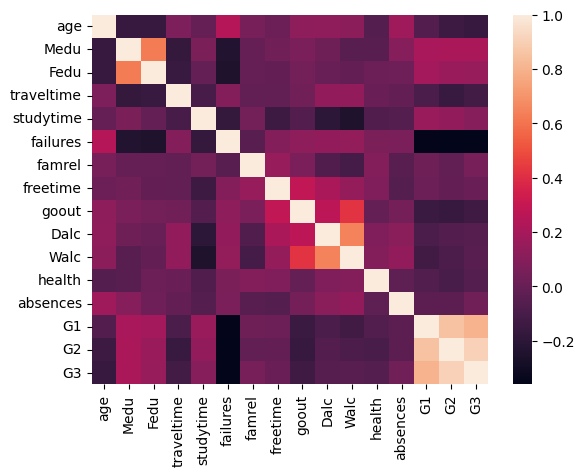

In [9]:
sns.heatmap(cor)

In [17]:
n = 4
top_vars = cor['G1'].abs().sort_values(ascending=False)[1:n+1].index.tolist()

In [18]:
top_vars

['G2', 'G3', 'failures', 'Medu']

In [24]:
df['G1'].value_counts()

10    51
8     41
11    39
7     37
12    35
13    33
9     31
14    30
15    24
6     24
16    22
18     8
17     8
5      7
19     3
4      1
3      1
Name: G1, dtype: int64

In [27]:
df['failures'].value_counts()

0    312
1     50
2     17
3     16
Name: failures, dtype: int64

In [28]:
from sklearn.preprocessing import LabelEncoder
lc = LabelEncoder()
df['age'] = lc.fit_transform(df['age'])
df['failures'] = lc.fit_transform(df['failures'])
df['studytime'] = lc.fit_transform(df['studytime'])
df['freetime'] = lc.fit_transform(df['freetime'])
df['health'] = lc.fit_transform(df['health'])
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,3,U,GT3,A,4,4,at_home,teacher,...,4,2,4,1,1,2,6,5,6,6
1,GP,F,2,U,GT3,T,1,1,at_home,other,...,5,2,3,1,1,2,4,5,5,6
2,GP,F,0,U,LE3,T,1,1,at_home,other,...,4,2,2,2,3,2,10,7,8,10
3,GP,F,0,U,GT3,T,4,2,health,services,...,3,1,2,1,1,4,2,15,14,15
4,GP,F,1,U,GT3,T,3,3,other,other,...,4,2,2,1,2,4,4,6,10,10


<AxesSubplot: xlabel='age', ylabel='count'>

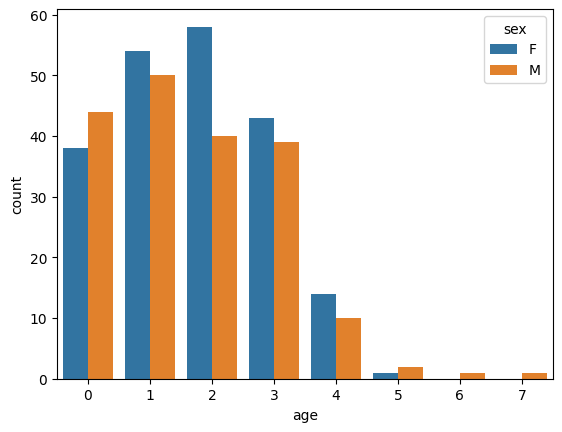

In [33]:
sns.countplot(x = df['age'] , hue = df['sex'])

<AxesSubplot: xlabel='school', ylabel='count'>

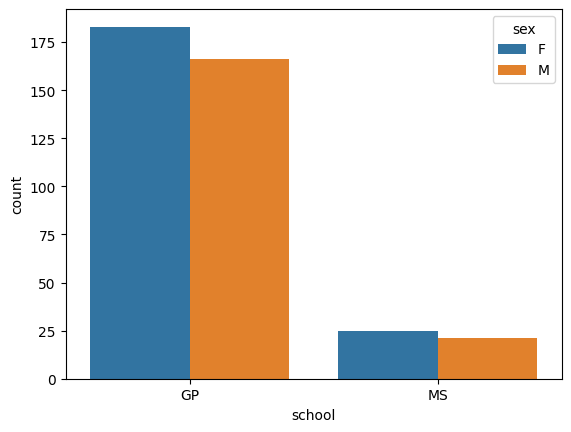

In [35]:
sns.countplot(x = df['school'] , hue = df['sex'])

<AxesSubplot: >

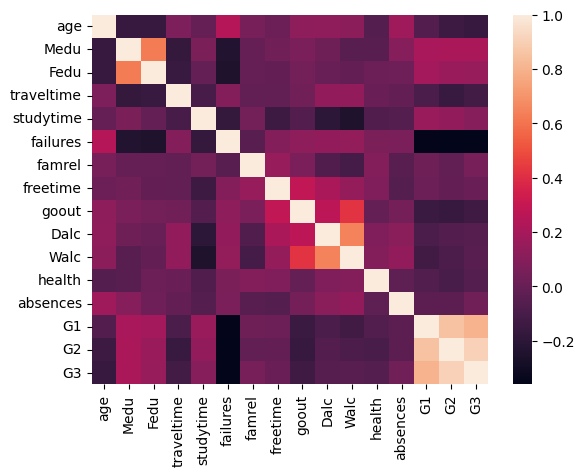

In [36]:
sns.heatmap(cor)

In [40]:
dx = df.drop(['G1' , 'G2'], axis = 1)
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,3,U,GT3,A,4,4,at_home,teacher,...,4,2,4,1,1,2,6,5,6,6
1,GP,F,2,U,GT3,T,1,1,at_home,other,...,5,2,3,1,1,2,4,5,5,6
2,GP,F,0,U,LE3,T,1,1,at_home,other,...,4,2,2,2,3,2,10,7,8,10
3,GP,F,0,U,GT3,T,4,2,health,services,...,3,1,2,1,1,4,2,15,14,15
4,GP,F,1,U,GT3,T,3,3,other,other,...,4,2,2,1,2,4,4,6,10,10


In [41]:
from sklearn.model_selection import train_test_split
y = df['G3']
x = df.drop(['G3'], axis  = 1)
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2, random_state = 0)

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [43]:
model = LogisticRegression(solver='liblinear', random_state=0)

In [48]:
for column in df.columns:
    print(f"{column}: {df[column].dtype}")

school: object
sex: object
age: int64
address: object
famsize: object
Pstatus: object
Medu: int64
Fedu: int64
Mjob: object
Fjob: object
reason: object
guardian: object
traveltime: int64
studytime: int64
failures: int64
schoolsup: object
famsup: object
paid: object
activities: object
nursery: object
higher: object
internet: object
romantic: object
famrel: int64
freetime: int64
goout: int64
Dalc: int64
Walc: int64
health: int64
absences: int64
G1: int64
G2: int64
G3: int64


AttributeError: 'DataFrame' object has no attribute 'dtype'

In [50]:
type(x_train)

pandas.core.frame.DataFrame

In [51]:
model.fit(x_train, y_train)

ValueError: could not convert string to float: 'GP'